*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/nlp-with-pytorch/blob/master/chapter_4/4_mlp_2d_points/2Dimensional_Perceptron_MLP.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/nlp-with-pytorch/blob/master/chapter_4/4_mlp_2d_points/2Dimensional_Perceptron_MLP.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

## 설정

In [2]:
LABELS = [0, 0, 1, 1]
CENTERS = [(-3, -3), (3, 3), (3, -3), (-3, 3)]

## 모델 정의

In [3]:
class MultilayerPerceptron(nn.Module):
    """
    """
    def __init__(self, input_size, hidden_size=2, output_size=3,
                 num_hidden_layers=1, hidden_activation=nn.Sigmoid):
        """가중치 초기화

        매개변수:
            input_size (int): 입력 크기
            hidden_size (int): 은닉층 크기
            output_size (int): 출력 크기
            num_hidden_layers (int): 은닉층 개수
            hidden_activation (torch.nn.*): 활성화 함수
        """
        super(MultilayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()

        interim_input_size = input_size
        interim_output_size = hidden_size

        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size)) # module_list 에다 nn.Linear,hidden_activation를 append (perceptron하나씩 지나갈때 activation지남)
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size

        self.fc_final = nn.Linear(interim_input_size, output_size)

        self.last_forward_cache = []  #last_forward_cache 리스트 생성

    def forward(self, x, apply_softmax=False): #forward함수를 지나갈때
        """MLP의 정방향 계산

        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서
                x_in.shape는 (batch, input_dim)입니다.
            apply_softmax (bool): 소프트맥스 함수를 위한 플래그
                크로스 엔트로피 손실을 사용하려면 반드시 False로 지정해야 합니다
        반환값:
            결과 텐서. tensor.shape는 (batch, output_dim)입니다.
        """
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy()) #append

        for module in self.module_list: #hidden layer하나씩 넣는다.
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy()) #forward함수 지나갈때마다 last_forward_cache에 x값을 append (to("cpu").data.numpy()는 gpu에 tensor상태를 cpu에 옮겨주겠다)(gpu는 연산할때만 사용, cpu는 값만 확인할때)

        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)

        return output

## 데이터 생성 함수

In [4]:
def get_toy_data(batch_size):
    assert len(CENTERS) == len(LABELS), 'centers should have equal number labels'

    x_data = []
    y_targets = np.zeros(batch_size)
    n_centers = len(CENTERS)

    for batch_i in range(batch_size):
        center_idx = np.random.randint(0, n_centers)
        x_data.append(np.random.normal(loc=CENTERS[center_idx])) # 위 centers 리스트중 하나를 중심으로 잡고 정규분포에서 하나를 뽑아서 x_data에 넣는다.
        y_targets[batch_i] = LABELS[center_idx]

    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int64)

## 결과 시각화 함수

In [5]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None,
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    _, y_pred = perceptron(x_data, apply_softmax=True).max(dim=1)
    y_pred = y_pred.data.numpy()

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy()


    n_classes = len(set(LABELS))

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]

    colors = ['orange', 'green']
    markers = ['o', '*']
    edge_color = {'o':'orange', '*':'green'}

    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:# 예측값이랑 맞춘거랑 같으면 white(비어있음)
            all_colors[y_true_i].append('white')
        else:
            all_colors[y_true_i].append(colors[y_true_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))

    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor=edge_color[marker], marker=marker, facecolor=color_list, s=100)


    xlim = (min([x_list[:,0].min() for x_list in all_x]),
            max([x_list[:,0].max() for x_list in all_x]))

    ylim = (min([x_list[:,1].min() for x_list in all_x]),
            max([x_list[:,1].max() for x_list in all_x]))

    # 초평면
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    for i in range(n_classes):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32),
                       apply_softmax=True)
        Z  = Z[:, i].data.numpy().reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)

    # 부가 출력
    plt.suptitle(title)

    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

## 초기 데이터 그래프

<ipython-input-4-625b9680f87f>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int64)


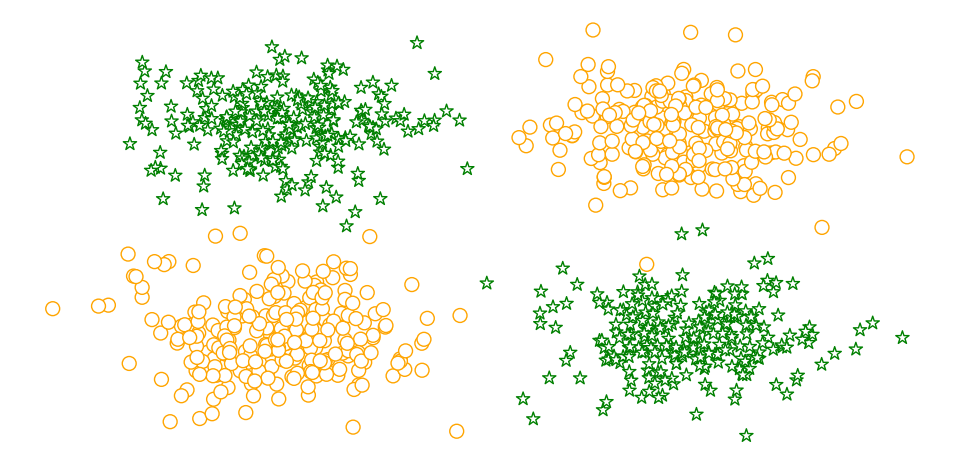

In [6]:
seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000) #batch size = 1000

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy().astype(np.int64)

n_classes = len(set(LABELS))

all_x = [[] for _ in range(n_classes)]
all_colors = [[] for _ in range(n_classes)]

colors = ['orange', 'green']
markers = ['o', '*']

for x_i, y_true_i in zip(x_data, y_truth):
    all_x[y_true_i].append(x_i)
    all_colors[y_true_i].append(colors[y_true_i])

all_x = [np.stack(x_list) for x_list in all_x]


_, ax = plt.subplots(1, 1, figsize=(10,5))

for x_list, color, marker in zip(all_x, all_colors, markers):
    ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor=color, marker=marker, facecolor="white", s=100)

plt.tight_layout()
plt.axis('off')

plt.title("");

plt.savefig("initial_data.png", dpi=300)

In [7]:
print(x_data)
len(x_data)  #numpy array (파이썬이랑 비슷하지만 다름)

[[ 2.771182  -3.1051946]
 [ 2.3904393  1.7719052]
 [-3.1335294 -1.5222008]
 ...
 [-4.7363553 -5.493645 ]
 [-3.752318   3.4247835]
 [-3.5867133  3.925775 ]]


1000

## 퍼셉트론 훈련

하나의 퍼셉트론은 하나의 다층 퍼셉트론입니다. 이를 잘 드러내기 위해 변수 이름을 `mlp1`이라고 쓰겠습니다. 위에서 정의한 클래스에 `num_hidden_layers=0`를 지정해 퍼셉트론을 만들겠습니다.

MultilayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


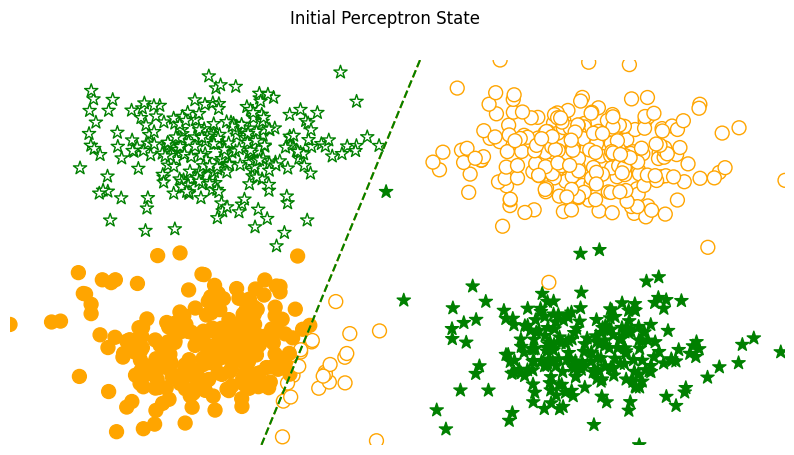

In [8]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 0 ## hidden layer =0  perceptron 하나 만든거랑 동일
hidden_size = 2 # 실제로 사용하지 않지만 지정합니다

seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp1 = MultilayerPerceptron(input_size=input_size,
                            hidden_size=hidden_size,
                            num_hidden_layers=num_hidden_layers,
                            output_size=output_size)
print(mlp1)
batch_size = 1000 # 이거로 학습

# 1_x_1 * w1 , 1_x_2 * w2
# 2_x_1 * w1 , 2_x_2 * w2
# 3_x_1 * w1 , 3_x_3 * w2

# (1_x_1, 1_x_2)                       (1_x_1 * w1 , 1_x_2 * w2)
# (2_x_1, 2_x_2)   *   (w1)  =         (2_x_1 * w1 , 2_x_2 * w2)
# (3_x_1, 3_x_2)       (w2)            (3_x_1 * w1 , 3_x_3 * w2)
# ...1000개까지 batch

# (3 * 2) matrix  (2 * 1) matrix  =>  (3*1) matrix

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, #visualize_results 로 결과 출력, 모델을 가져와서 경계를 찍음
                  ax=ax, title='Initial Perceptron State', levels=[0.5])

plt.axis('off')
plt.savefig('perceptron_initial.png', dpi=300)

#학습시도

In [13]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-3
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp1.parameters(), lr=lr) #Adam optimizer
cross_ent_loss = nn.CrossEntropyLoss() # cross entropy , binary classification

def early_termination(loss_change, change_threshold, epoch, max_epochs): #학습을 중지시킬지 말지의 함수
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs #if epoch > max_epochs: true or false 반환이라서 둘중하나를 반환해서 대입

    return terminate_for_epochs # 함수내의 변수명(함수밖에서는 사용불가)

#if epoch > max_epochs:

while not early_termination(loss_change, change_threshold, epoch, max_epochs):#일찍 끝나지 마라의 not이니 일찍끝나라
    for _ in range(n_batches):
        # 단계 0: 데이터 추출
        x_data, y_target = get_toy_data(batch_size)

        # 단계 1: 그레이디언트 초기화
        mlp1.zero_grad()

        # 단계 2: 정방향 계산 수행
        y_pred = mlp1(x_data).squeeze()

        # 단계 3: 손실 계산
        loss = cross_ent_loss(y_pred, y_target.long())

        # 단계 4: 역방향 계산
        loss.backward() #gradient계산

        # 단계 5: 옵티마이저 단계 수행
        optimizer.step() #weight를 업데이트

        # 부가 정보
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(mlp1, x_data_static, y_truth_static, ax=ax, epoch=epoch,
                      title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'perceptron_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1], dpi=300)

Output hidden; open in https://colab.research.google.com to view.

## 2개 층을 가진 다층 퍼셉트론 훈련하기

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


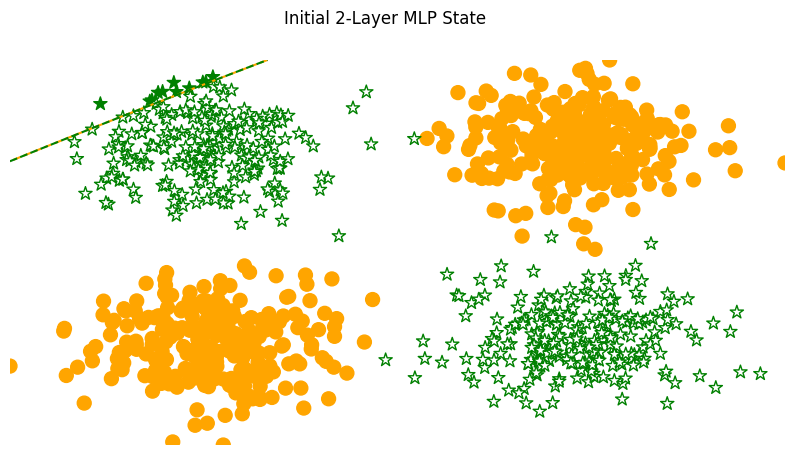

In [14]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 1 #hidden layer를 1로했음. 위에 hidden layer를 0일때는 학습이 안됨. MLP로 몇개씩 hidden layer를 쌓아여 모델파워가 좋아지는거 증명, 학습전상태 그림확인
hidden_size = 2

seed = 2

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp2 = MultilayerPerceptron(input_size=input_size,
                           hidden_size=hidden_size,
                           num_hidden_layers=num_hidden_layers,
                           output_size=output_size)
print(mlp2)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp2, x_data_static, y_truth_static,
                  ax=ax, title='Initial 2-Layer MLP State', levels=[0.5])

plt.axis('off')
plt.savefig('mlp2_initial.png', dpi=300);

In [15]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 15

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp2.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs

    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # 단계 0: 데이터 추출
        x_data, y_target = get_toy_data(batch_size)

        # 단계 1: 그레이디언트 초기화
        mlp2.zero_grad()

        # 단계 2: 정방향 계산
        y_pred = mlp2(x_data).squeeze()

        # 단계 3: 손실 계산
        loss = cross_ent_loss(y_pred, y_target.long())

        # 단계 4: 역방향 계산
        loss.backward()

        # 단계 5: 옵티마이저 단계 수행
        optimizer.step()

        # 부가정보
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(mlp2, x_data_static, y_truth_static, ax=ax, epoch=epoch,
                      title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'mlp2_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1], dpi=300)

Output hidden; open in https://colab.research.google.com to view.

## 3개 층을 가진 다층 퍼셉트론 훈련하기

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


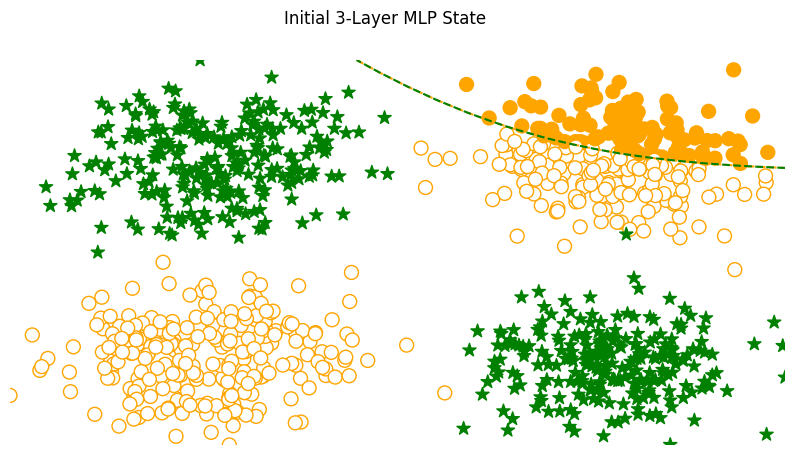

In [11]:
input_size = 2 #2는 맞음, data가 2차원이라서
output_size = len(set(LABELS))  #output도 2 , 왜나면 0아니면 1을 맞춰야되서
num_hidden_layers = 2 # hidden layer 2개짜리
hidden_size = 2

seed = 399

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp3 = MultilayerPerceptron(input_size=input_size,  # num_hidden_layers = 2
                           hidden_size=hidden_size,  #표현분석을 하기위해 2로 지정, 8차원같은건 볼수 없어서 중간층인 2차원을 지정함
                           num_hidden_layers=num_hidden_layers,
                           output_size=output_size)
print(mlp3)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp3, x_data_static, y_truth_static,
                  ax=ax, title='Initial 3-Layer MLP State', levels=[0.5])

plt.axis('off')
plt.savefig('mlp3_initial.png', dpi=300);

In [16]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp3.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs

    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # 단계 0: 데이터 추출
        x_data, y_target = get_toy_data(batch_size)

        # 단계 1: 그레이디언트 초기화
        mlp3.zero_grad()

        # 단계 2: 정방향 계산
        y_pred = mlp3(x_data).squeeze()

        # 단계 3: 손실 계산
        loss = cross_ent_loss(y_pred, y_target.long())

        # 단계 4: 역방향 계산
        loss.backward()

        # 단계 5: 옵티마이저 단계 수행
        optimizer.step()

        # 부가정보
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value

    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(mlp3, x_data_static, y_truth_static, ax=ax, epoch=epoch,
                      title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'mlp3_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1], dpi=300)

Output hidden; open in https://colab.research.google.com to view.

위 결과 이미지를 파일로 저장

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('perceptron_final.png', dpi=300)

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('mlp2_final.png', dpi=300)

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('mlp3_final.png', dpi=300)

In [ ]:
_, axes = plt.subplots(1,2,figsize=(12,5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[0])
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
plt.tight_layout()
axes[0].axis('off');
axes[1].axis('off');
plt.savefig("perceptron_vs_mlp2.png", dpi=300)

In [ ]:
_, axes = plt.subplots(1,2,figsize=(12,5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[0])
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
plt.tight_layout()
axes[0].axis('off');
axes[1].axis('off');
plt.savefig("perceptron_vs_mlp3.png", dpi=300)

In [ ]:
_, axes = plt.subplots(1,3,figsize=(16,5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[0])
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[2])
plt.tight_layout()
axes[0].axis('off');
axes[1].axis('off');
axes[2].axis('off');
plt.savefig("perceptron_vs_mlp2_vs_mlp3.png", dpi=300)

### 표현 분석

In [17]:
batch_size = 100

In [18]:
def plot_intermediate_representations(mlp_model, plot_title, figsize=(10,2)):
    x_data, y_target = get_toy_data(batch_size)

    y_pred = mlp_model(x_data, True).detach().numpy()

    x_data = x_data.numpy()
    y_target = y_target.numpy()

    colors = ['orange', 'green']
    markers = ['o', '*']

    #     plot_colors = []
    #     for i in range(y_target.shape[0]):
    #         plot_colors.append(colors[y_target[i]])

    plot_markers = []
    class_zero_indices = []
    class_one_indices = []
    for i in range(y_target.shape[0]):
        if y_target[i] == 0:
            class_zero_indices.append(i)
        else:
            class_one_indices.append(i)
    class_zero_indices = np.array(class_zero_indices)
    class_one_indices = np.array(class_one_indices)
    # plot_markers.append(markers[y_target[i]])

    fig, axes = plt.subplots(1, len(mlp_model.last_forward_cache), figsize=figsize)

    for class_index, data_indices in enumerate([class_zero_indices, class_one_indices]):

        axes[0].scatter(x_data[data_indices,0], x_data[data_indices,1], edgecolor=colors[class_index], facecolor="white",
                            marker=markers[class_index], s=[200,400][class_index])
        axes[0].axis('off')
        for i, activations in enumerate(mlp_model.last_forward_cache[1:], 1): #axes.scatter 로 그림으로 보여줌
            axes[i].scatter(activations[data_indices,0], activations[data_indices,1], edgecolor=colors[class_index], facecolor="white",
                            marker=markers[class_index], s=[200,400][class_index])
            axes[i].axis('off')

    plt.tight_layout()

    plt.suptitle(plot_title, size=15)
    plt.subplots_adjust(top=0.75)

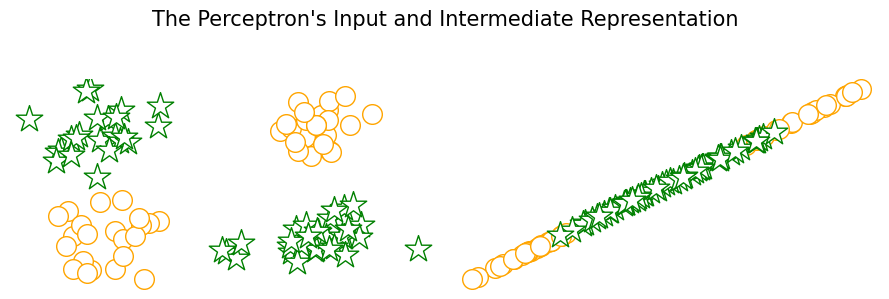

In [19]:
plot_intermediate_representations(mlp1,
                                  "The Perceptron's Input and Intermediate Representation",
                                  figsize=(9, 3))
plt.savefig("perceptron_intermediate.png", dpi=300)

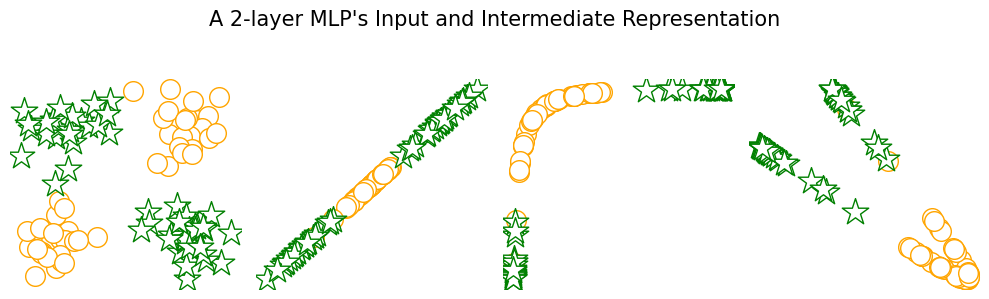

In [20]:
plot_intermediate_representations(mlp2,
                                  "A 2-layer MLP's Input and Intermediate Representation",
                                  figsize=(10, 3))
plt.savefig("mlp2_intermediate.png", dpi=300)

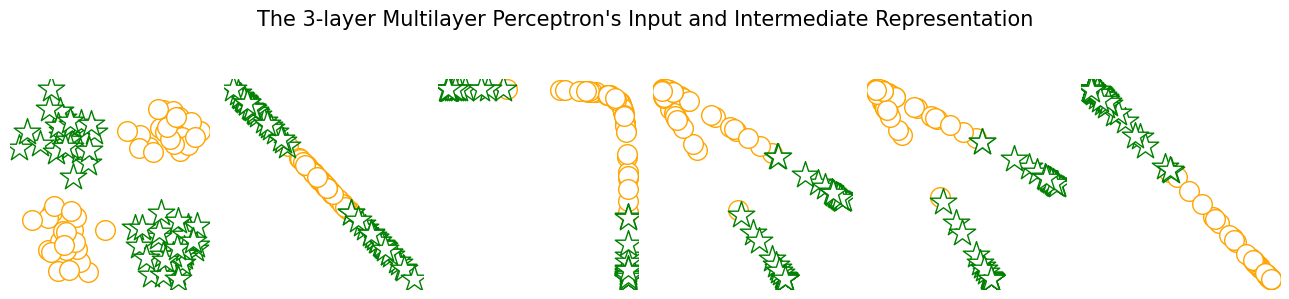

In [21]:
plot_intermediate_representations(mlp3,
                                  "The 3-layer Multilayer Perceptron's Input and Intermediate Representation",
                                  figsize=(13, 3))
plt.savefig("mlp3_intermediate.png", dpi=300)

In [ ]:
# x1, x2

# x1 * w1 + x2 * w2 => h1
#perceptron 하나 지나면 값이 하나만 나옴 (스칼라)

#2개면 값2개  = output dimension
